## Importing Necessary Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_lfw_people
import cv2
import numpy

## Loading Dataset (preprocessing + train-test split)

__We are taking the image of only those classes which have atleast 70 image and resizing the image__

In [ ]:
lfw_people = fetch_lfw_people(min_faces_per_person=70,resize=0.4)
n_samples, h, w = lfw_people.images.shape

__X          : is the Matrix of Images with images being in column__
<br>
__n_features : is no of images in Dataset__
<br>
__y          : contains the label of each Image__
<br>
__n_classes  : represents No of distinct images__ 

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


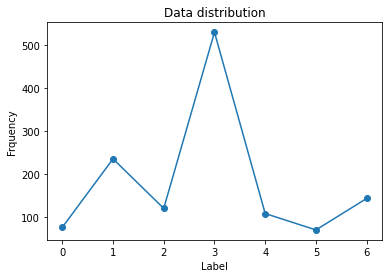

In [ ]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)

X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
unique, counts = numpy.unique(y, return_counts=True)

target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

plt.plot(unique, counts, marker='o')
plt.xlabel('Label')
plt.ylabel('Frquency')
plt.title('Data distribution')
plt.show()

__Spliting the Dataset in test and train with percentage of test dataset being 30%__

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(966, 1850)
(322, 1850)
(966,)
(322,)


## Implementation of LDA (Scratch)

**Importing all the libraries required for LDA**

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.simplefilter("ignore")

num_classes = n_classes

### Helper functions

In [ ]:
# compute the mean matrix for each of the 7 classes
def compute_classes_mean_matrix(train_data,train_labels, num_classes):
    '''
    This function computes mean for each class. The output dimension
    will be Cxm (C-number of classes; m-number of features)
    Input:
      @param train_data: features of training samples (X_train)
      @param train_labels: labels of training samples (y_train)
      @param num_classes: number of classes
    Output:
      return [list[list]]: list of class means
    '''
    means = np.zeros((num_classes, train_data.shape[1]))
    # train_test_split_ratio = 3
    for i in range(0,num_classes):
        temp = np.where(train_labels == i)[0]
        temp_sum = np.zeros((1,train_data.shape[1]))
        for j in temp:
           temp_sum += train_data[j,:]
        Ni = len(temp)
        means[i,:] = temp_sum / Ni
    return means

In [ ]:
def compute_overall_mean(train_data):
  '''
  This function computes overall mean of training dataset
  (average image for all classes in the training dataset).
  The output dimension will be 1x1
  Input:
    @param train_data: features of training samples (X_train)
  Output:
    return overall_mean: overall mean of training samples
  '''
  temp_sum = np.zeros((1,train_data.shape[1]))
  for i in range(train_data.shape[0]):
    temp_sum += train_data[i,:]
  overall_mean = temp_sum/train_data.shape[0]
  return overall_mean

In [ ]:
#the matrix of the overall scatter between all the classes
def compute_between_class_scatter_matrix(train_labels, classes_means,overall_mean):
    '''
    This function will compute scatter matrix between all the
    classes available with the image dataset its computed on 
    variance of each class by using overall means
    Input:
      @param train_labels: labels of training samples (y_train)
      @param classes_means: classwise mean of training samples
      @param overall_mean: overall mean of training samples
    Output:
      return Sb: between class scatter matrix
    '''
    Sb = np.zeros((classes_means.shape[1],classes_means.shape[1]))
    for i in range(classes_means.shape[0]):
        Ni = len(np.where(train_labels==i)[0])
        Sb = np.add(Sb,Ni* ((classes_means[i] - overall_mean) * (classes_means[i] - overall_mean).T))
    return Sb

In [ ]:
def compute_center_class_matrix(train_data,train_labels,classes_means):
    '''
    Here we will compute center clas scatter for each and every data or image 
    for which we will do subtract class mean of each class data to obtain center 
    class scatter matrix.
    Input:
      @param train_data: features of training samples (X_train)
      @param train_labels: labels of training samples (y_train)
      @param classes_means: classwise mean of training samples
    Output:
      return Z: center class matrix
    '''
    Z = np.zeros(train_data.shape)
    for i in range(train_data.shape[0]):
        Z[i,:] = train_data[i,:] - classes_means[int(train_labels[i])-1,:]

    return Z

In [ ]:
def compute_class_scatter_matrix(Z, shape_):
    '''
    this will give class scatter matrix on center class scatter 
    which we have computed for each data/image and we will do linear 
    transformation to get it.
    Input:
      @param Z: center class matrix
      @param shape_: Number of training samples
    Output:
      return S: class scatter matrix
    '''
    S = np.zeros((shape_,shape_))
    S = np.dot(Z.T,Z)
    print("The shape of scatter matrix",S.shape)
    return S 

In [ ]:
def data_dimencionality_reduction(train_data,test_data, num_classes):
    '''
    this will be last step to get reduced dimension labelled data/images
    where we input train and test data along with number of classes to
    obtain finally reduced dimension data.
    '''
    train_data_dimensionally_reductuted = np.zeros((train_data.shape[0],num_classes)) 
    test_data_dimensionally_reductuted = np.zeros((test_data.shape[0],num_classes)) 
    
    i=0
    for img in train_data:
        train_data_dimensionally_reductuted[i,:]=np.dot(img,eigen_vectors)
        i+=1
    i=0
    for img in test_data:
        test_data_dimensionally_reductuted[i,:] = np.dot(img,eigen_vectors)
        i+=1
        
    return train_data_dimensionally_reductuted,test_data_dimensionally_reductuted

In [ ]:
def plot_accuracy_graph(accuracy, k_list):
    '''
    this will plot the graph for accuracy of target image 
    classified correctly or not
    '''
    plt.figure(figsize=(12, 6))
    plt.plot(k_list, accuracy, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)
    # plt.ylim(0, 70)
    plt.title('Accuracy for each K Value')
    plt.xlabel('K Value')
    plt.ylabel('Accuracy %')

### Compute LDA

In [ ]:
classes_means = compute_classes_mean_matrix(X_train,y_train, num_classes)
print("Class Means: ", classes_means.shape)
print('Done classes means computing')
print('-----------------------------------------------------------')

Class Means:  (7, 1850)
Done classes means computing
-----------------------------------------------------------


In [ ]:
overall_mean = compute_overall_mean(X_train)
print("Overall Mean: ", overall_mean.shape)
print('Done overall mean computing')
print('-----------------------------------------------------------')

Overall Mean:  (1, 1850)
Done overall mean computing
-----------------------------------------------------------


In [ ]:
S_between = compute_between_class_scatter_matrix(y_train, classes_means,overall_mean)
print("Sb: ", S_between.shape)
print('Done between class scater matrix computing')
print('-----------------------------------------------------------')

Sb:  (1850, 1850)
Done between class scater matrix computing
-----------------------------------------------------------


In [ ]:
Z = compute_center_class_matrix(X_train, y_train, classes_means)
print("Z: ", Z.shape)
print('Done center class scatter matrix computing')
print('-----------------------------------------------------------')

Z:  (966, 1850)
Done center class scatter matrix computing
-----------------------------------------------------------


In [ ]:
S_classes = compute_class_scatter_matrix(Z, X_train.shape[1])
print("Sw: ", S_classes.shape)
print('Done within class scatter matrix computing')
print('-----------------------------------------------------------')

The shape of scatter matrix (1850, 1850)
Sw:  (1850, 1850)
Done within class scatter matrix computing
-----------------------------------------------------------


In [ ]:
W_value = np.dot(np.linalg.inv(S_classes),S_between)
print('Done W = Sw^(-1)*Sb  computing')
print('-----------------------------------------------------------')
print("W: ", W_value.shape)

Done W = Sw^(-1)*Sb  computing
-----------------------------------------------------------
W:  (1850, 1850)


In [ ]:
#7 largest eigen values
eigen_values,eigen_vectors = scipy.linalg.eigh(W_value,eigvals=((X_train.shape[1]-num_classes+1),(X_train.shape[1]-1)))
print("Eigen Values: ", eigen_values.shape)
print("Eigen Vectors: ", eigen_vectors.shape)
# eigen_values = eigen_values[::-1]
print(eigen_values)

Eigen Values:  (6,)
Eigen Vectors:  (1850, 6)
[ 5909.19568366  7719.32672338 11667.00126478 14720.8903169
 16952.15829738 38222.26570415]


In [ ]:
#reduce dimensionality of both train and test data sets
train_data_dimensionally_reductuted,test_data_dimensionally_reductuted = data_dimencionality_reduction(X_train,X_test, num_classes-1)

### Apply KNN

Accuracy Max:  59.006211180124225  Index:  6


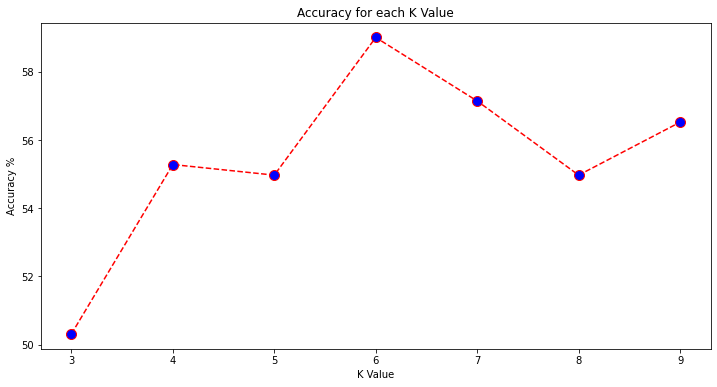

In [ ]:
accuracy = []
max = -1
index = -1
#Apply KNN
k_list = [i for i in range(3, 10)]
for i in k_list:
    classifier = KNeighborsClassifier(n_neighbors=i)
    classifier.fit(train_data_dimensionally_reductuted, y_train)

    test_predict = classifier.predict(test_data_dimensionally_reductuted)
    
    true_predicted_count=0
    for j in range(0,len(test_predict)):
        if test_predict[j] ==y_test[j]:
            true_predicted_count+=1
    accuracy.append((true_predicted_count/len(test_predict))*100)
    if max<(true_predicted_count/len(test_predict))*100:
      max = (true_predicted_count/len(test_predict))*100
      index = i

#plot graph for different K values
plot_accuracy_graph(accuracy, k_list)
print("Accuracy Max: ",max," Index: ",index)

## Analysis on predicted samples

In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
misclassification = {}
for j in range(0,len(test_predict)):
  if test_predict[j] !=y_test[j]:
    if y_test[j] in misclassification.keys():
      misclassification[y_test[j]].append(test_predict[j])
    else:
      misclassification[y_test[j]] = [test_predict[j]]

for cl in misclassification:
  temp = {}
  cl_predict, cl_counts = np.unique(misclassification[cl], return_counts=True)
  for i in range(len(cl_predict)):
    temp[cl_predict[i]] = cl_counts[i]
  print("Class: ", cl, "\t#samples: ", counts[int(cl)], "\t#misclassified: ",len(misclassification[cl]), "\t%miss: ", round((len(misclassification[cl])/counts[cl])*100,2), "\tMiss samples: ", temp)

Class:  6 	#samples:  36 	#misclassified:  27 	%miss:  75.0 	Miss samples:  {0: 2, 1: 5, 3: 19, 4: 1}
Class:  4 	#samples:  25 	#misclassified:  20 	%miss:  80.0 	Miss samples:  {1: 4, 3: 9, 5: 1, 6: 6}
Class:  3 	#samples:  146 	#misclassified:  33 	%miss:  22.6 	Miss samples:  {0: 1, 1: 18, 2: 5, 5: 4, 6: 5}
Class:  2 	#samples:  27 	#misclassified:  16 	%miss:  59.26 	Miss samples:  {0: 2, 1: 4, 3: 6, 4: 1, 6: 3}
Class:  1 	#samples:  60 	#misclassified:  28 	%miss:  46.67 	Miss samples:  {0: 4, 2: 5, 3: 14, 4: 1, 6: 4}
Class:  0 	#samples:  13 	#misclassified:  8 	%miss:  61.54 	Miss samples:  {1: 6, 6: 2}
Class:  5 	#samples:  15 	#misclassified:  8 	%miss:  53.33 	Miss samples:  {3: 4, 4: 3, 6: 1}


## Inbuilt LDA

In [ ]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
clf = LDA()
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
correct = 0
for i in range(y_test.shape[0]):
  if predictions[i]==y_test[i]:
    correct += 1

print("Accuracy: ", (correct/len(predictions)))

Accuracy:  0.7018633540372671


In [ ]:
unique, counts = np.unique(y_test, return_counts=True)
misclassification = {}
for j in range(0,len(predictions)):
  if predictions[j] !=y_test[j]:
    if y_test[j] in misclassification.keys():
      misclassification[y_test[j]].append(predictions[j])
    else:
      misclassification[y_test[j]] = [predictions[j]]

for cl in misclassification:
  temp = {}
  cl_predict, cl_counts = np.unique(misclassification[cl], return_counts=True)
  for i in range(len(cl_predict)):
    temp[cl_predict[i]] = cl_counts[i]
  print("Class: ", cl, "\t#samples: ", counts[int(cl)], "\t#misclassified: ",len(misclassification[cl]), "\t%miss: ", round((len(misclassification[cl])/counts[cl])*100,2), "\tMiss samples: ", temp)

Class:  3 	#samples:  146 	#misclassified:  33 	%miss:  22.6 	Miss samples:  {0: 1, 1: 11, 2: 8, 4: 3, 5: 1, 6: 9}
Class:  2 	#samples:  27 	#misclassified:  12 	%miss:  44.44 	Miss samples:  {0: 1, 3: 4, 5: 2, 6: 5}
Class:  1 	#samples:  60 	#misclassified:  17 	%miss:  28.33 	Miss samples:  {0: 2, 2: 2, 3: 5, 4: 2, 5: 4, 6: 2}
Class:  5 	#samples:  15 	#misclassified:  7 	%miss:  46.67 	Miss samples:  {2: 1, 3: 3, 4: 3}
Class:  6 	#samples:  36 	#misclassified:  13 	%miss:  36.11 	Miss samples:  {0: 1, 1: 4, 2: 1, 3: 2, 4: 5}
Class:  4 	#samples:  25 	#misclassified:  8 	%miss:  32.0 	Miss samples:  {1: 1, 2: 1, 3: 3, 6: 3}
Class:  0 	#samples:  13 	#misclassified:  6 	%miss:  46.15 	Miss samples:  {1: 2, 2: 2, 3: 1, 4: 1}


## Visualizing the data with TSNE

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=50)
pca_result = pca.fit_transform(X_train)

Text(0.5, 1.0, 'T-SNE plot for first 5000 training samples')

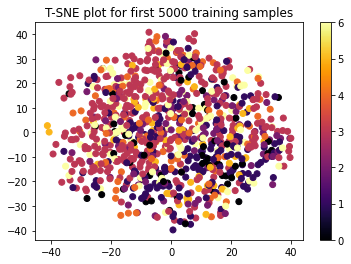

In [ ]:
X_embedded = TSNE(n_components=3,learning_rate='auto',init='random').fit_transform(pca_result)
plt.scatter(x=X_embedded[:,0],y=X_embedded[:,1],c=y_train,cmap='inferno')#'inferno')
plt.colorbar()
plt.title("T-SNE plot for first 5000 training samples")

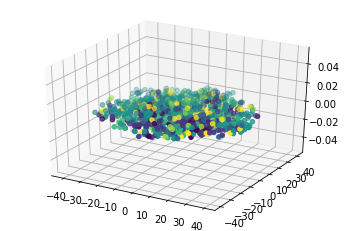

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:,0], X_embedded[:,1], zs=0, zdir='z', s=20, c=y_train, depthshade=True)